In [58]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint, random
from skimage.io import imread, imsave

import warnings #kindly fuck off
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
import imageio
from heapq import heapify, heappop, heappush

In [40]:
def randomcolor(eps=.1):
    r = round(random()/eps)*eps
    g = round(random()/eps)*eps
    b = round(random()/eps)*eps
    return (r,g,b)

def color_grid(boxes, grid):
    for b in boxes:
        c = randomcolor()
        grid[b.x:b.x+b.w,b.y:b.y+b.h,0] = c[0]
        grid[b.x:b.x+b.w,b.y:b.y+b.h,1] = c[1]
        grid[b.x:b.x+b.w,b.y:b.y+b.h,2] = c[2]
    return grid

def color_grid_from_image(boxes, grid, image):
    # Process image to 0-1
    image = image / 255
    for b in boxes:
        grid[b.x:b.x+b.w,b.y:b.y+b.h,0] = image[b.x:b.x+b.w,b.y:b.y+b.h,0].mean()
        grid[b.x:b.x+b.w,b.y:b.y+b.h,1] = image[b.x:b.x+b.w,b.y:b.y+b.h,1].mean()
        grid[b.x:b.x+b.w,b.y:b.y+b.h,2] = image[b.x:b.x+b.w,b.y:b.y+b.h,2].mean()
    return grid

In [53]:
img_path = "./skele.png"
#img_path = "/Users/ethan/Desktop/Face.jpeg"
#img_path = "/Users/ethan/Desktop/Wallpapers/Courthouse2.jpg"
#img_path = "/Users/ethan/Desktop/Wallpapers/us.jpg"
im = imread(img_path)
if im.shape[-1] == 4:
    im = im[:,:,:-1]
X_SIZE = im.shape[0]
Y_SIZE = im.shape[1]

class Box:
    
    def __init__(self, x, y, w, h, split_orient=0):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        if (x + w > X_SIZE) or (y + h > Y_SIZE):
            raise ValueError

        # For "alternating" option on we track which orient was used to create box.
        self.split_orient = split_orient 
            
    def __str__(self):
        return f"({self.x},{self.y},{self.w},{self.h})"
    
    def __repr__(self):
        return str(self)
    
    def __lt__(self, other):
        """
        Because I want to use this with heapq to get the BIGGEST box, this is actually returning
        whether the current box is BIGGER than the other one.
        """
        return self.area() > other.area()
        
    def area(self):
        return self.w*self.h
    
    def rand_split(self, orient="random"):
        """
        Splits the box, returning two new boxes in a tuple.
        """
        if orient == "random": 
            orientation = randint(0,1)
        elif orient == "alternating":
            orientation = int(not self.split_orient)
        elif orient == "horizontal":
            orientation = 1
        elif orient == "vertical":
            orientation = 0
        else:
            raise ValueError("orient must be 'random', 'horizontal' or 'vertical'")

        if orientation == 0: # Vertical cut
            cut = round(random()*self.h)
            box1 = Box(self.x, self.y, self.w, cut, split_orient=orientation)
            box2 = Box(self.x, self.y+cut, self.w, self.h-cut, split_orient=orientation)
        else: # Horizontal cut
            cut = round(random()*self.w)
            box1 = Box(self.x, self.y, cut, self.h, split_orient=orientation)
            box2 = Box(self.x+cut, self.y, self.w-cut, self.h, split_orient=orientation)
            
        return (box1, box2)

In [71]:
def pure_random_split(grid, init_box, n=20, orient="random"):
    if isinstance(init_box, Box):
        boxes = [init_box]
    else:
        boxes = init_box
    for t in range(n):
        # Choose a box at random
        idx = randint(0,len(boxes)-1)
        new_boxes = boxes[idx].rand_split(orient=orient)
        boxes = boxes[:idx] + list(new_boxes) + boxes[idx+1:]
    return boxes

def area_proportioned_split(grid, init_box, n=20, orient="random"):
    """
    Chooses to split a box with probability proportionate to its area.
    """
    if isinstance(init_box, Box):
        boxes = [init_box]
    else:
        boxes = init_box
    for t in range(n):
        # Choose a box
        areas = np.asarray([b.area() for b in boxes])
        areas = areas / areas.sum()
        idx = np.random.choice(range(len(boxes)),p=areas)
        new_boxes = boxes[idx].rand_split(orient=orient)
        boxes = boxes[:idx] + list(new_boxes) + boxes[idx+1:]
    return boxes


def sq_area_proportioned_split(grid, init_box, n=20, orient="random"):
    """
    Chooses to split a box with probability proportionate to its square area.
    """
    if isinstance(init_box, Box):
        boxes = [init_box]
    else:
        boxes = init_box
    for t in range(n):
        # Choose a box
        areas = np.asarray([b.area() for b in boxes])
        areas = areas**2
        areas = areas / areas.sum()
        idx = np.random.choice(range(len(boxes)),p=areas)
        new_boxes = boxes[idx].rand_split(orient=orient)
        boxes = boxes[:idx] + list(new_boxes) + boxes[idx+1:]
    return boxes


def always_largest_split(grid, init_box, n=20, orient="random"):
    """
    Chooses to split a box by always picking the largest box.
    """
    if isinstance(init_box, Box):
        boxes = [init_box]
    else:
        boxes = init_box
    for t in range(n):
        # Choose a box
        areas = np.asarray([b.area() for b in boxes]) # TODO use a heap, this is the slow part.
        idx = np.argmax(areas)
        new_boxes = boxes[idx].rand_split(orient=orient)
        boxes = boxes[:idx] + list(new_boxes) + boxes[idx+1:]
    return boxes


def always_largest_split_heap(grid, init_box, n=20, orient="random"):
    """
    Chooses to split a box by always picking the largest box.
    """
    if isinstance(init_box, Box):
        boxes = [init_box]
    else:
        boxes = heapify(init_box)
    for t in range(n):
        # Choose a box
        #print(type(boxes))
        box = heappop(boxes)
        new_boxes = box.rand_split(orient=orient)
        heappush(boxes, new_boxes[0])
        heappush(boxes, new_boxes[1])
        #boxes = boxes[:idx] + list(new_boxes) + boxes[idx+1:]
    return boxes

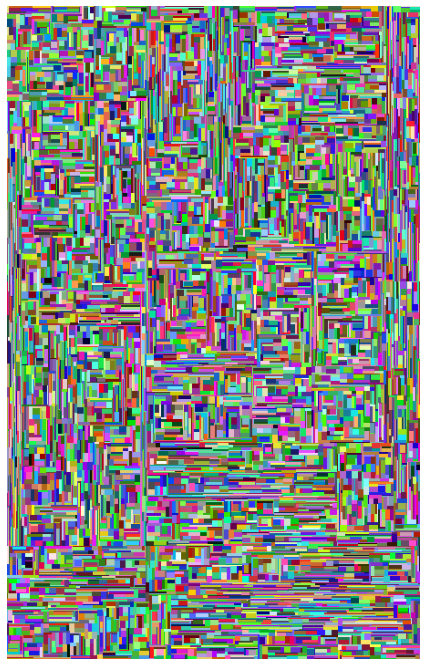

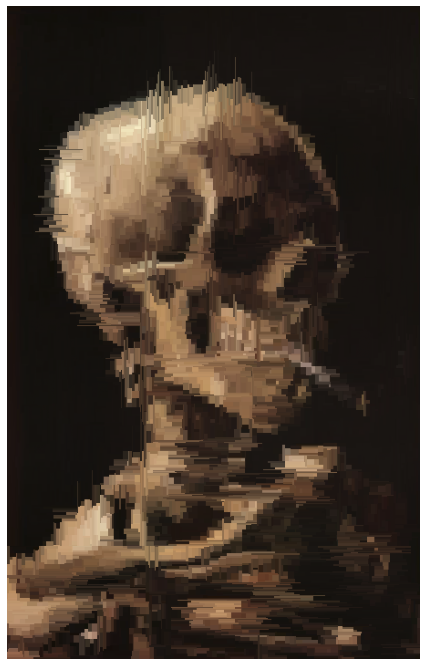

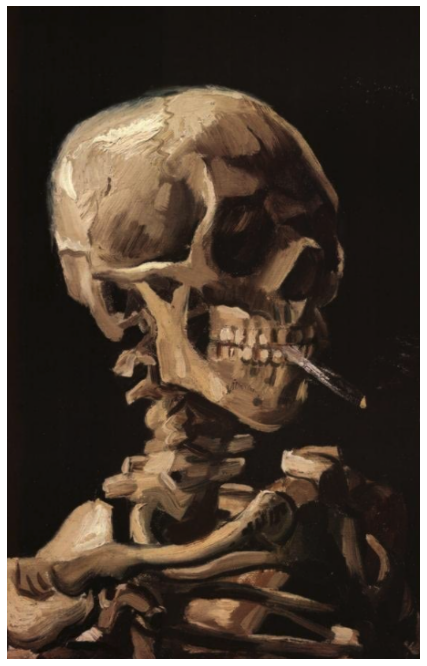

CPU times: user 934 ms, sys: 7.84 ms, total: 942 ms
Wall time: 939 ms


In [79]:
%%time
grid = np.zeros((X_SIZE, Y_SIZE, 3))
init_box = Box(0,0,X_SIZE,Y_SIZE)
im = imread(img_path)

boxes = always_largest_split_heap(grid, init_box, n=12000, orient="alternating")

grid = color_grid(boxes, grid)
plt.figure(figsize=(12,12))
plt.imshow(grid)
plt.axis("off")
plt.show()

grid = color_grid_from_image(boxes, grid, im)
plt.figure(figsize=(12,12))
plt.imshow(grid)
plt.axis("off")
plt.show()

plt.figure(figsize=(12,12))
plt.imshow(im)
plt.axis("off")
plt.show()

#imsave("1.png", grid)

In [85]:
frames = 300

images = []

im = imread(img_path)


init_box = Box(0,0,X_SIZE,Y_SIZE)

for i in tqdm(range(frames)):
    grid = np.zeros((X_SIZE, Y_SIZE, 3))

    boxes = always_largest_split_heap(grid, init_box, n=i*100, orient="alternating")

    grid = color_grid_from_image(boxes, grid, im)
    images.append(grid)

In [98]:
%%time
%%capture
imageio.mimsave('skele_prog_4.gif', images)

CPU times: user 59.7 s, sys: 2.19 s, total: 1min 1s
Wall time: 1min 2s


In [97]:
n = 1500
images = []
boxes = [init_box]
for t in tqdm(range(n)):
    # Choose a box
    #print(type(boxes))
    box = heappop(boxes)
    new_boxes = box.rand_split(orient="alternating")
    heappush(boxes, new_boxes[0])
    heappush(boxes, new_boxes[1])
    grid = color_grid_from_image(boxes, grid, im)
    images.append(grid)
    #boxes = boxes[:idx] + list(new_boxes) + boxes[idx+1:]

In [99]:
from pygifsicle import optimize
optimize("skele_prog_4.gif", "skele_prog_opt.gif")